In [1]:
import os
import numpy as np
import cv2
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.models as models
import matplotlib.pyplot as plt

/opt/anaconda3/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/opt/anaconda3/lib/python3.9/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: dlopen(/opt/anaconda3/lib/python3.9/site-packages/torchvision/image.so, 0x0006): Library not loaded: @rpath/libjpeg.8.dylib
  Referenced from: <90B45554-B79A-39BA-8A44-F2AD877B729C> /opt/anaconda3/lib/python3.9/site-packages/torchvision/image.so
  Reason: tried: '/opt/anaconda3/lib/python3.9/site-packages/torchvision/../../../libjpeg.8.dylib' (no such file), '/opt/anaconda3/lib/python3.9/site-packages/torchvision/../../../libjpeg.8.dylib' (no such file), '/opt/anaconda3/lib/python3.9/lib-dynload/../../libjpeg.8.dylib' (no such file), '/opt/anaconda3/bin/../lib/libjpeg.8.dylib' (no such file), '/System/Volumes/Preboot/Cryp

In [2]:
# Define the number of classes
num_classes = 20

In [3]:
data = []
labels = []

In [4]:
def set_device():
    device = "mps" if torch.backends.mps.is_available() else "cpu"
    return device

In [5]:
mobilenet=models.mobilenet_v2(pretrained=False, num_classes = 20)

/opt/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [6]:
device=set_device()

In [7]:
mobilenet.to(device)

MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

In [8]:
data_transforms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((244)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [9]:
for class_folder in os.listdir('../../data20/dataset_20_classes_training//'):
    class_folder_path = os.path.join('../../data20/dataset_20_classes_training/', class_folder)
    if os.path.isdir(class_folder_path):
        for file_name in os.listdir(class_folder_path):
            if file_name.endswith('.JPG'):
                img = cv2.imread(os.path.join(class_folder_path, file_name))
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  
                img= cv2.resize(img,(224,224))
                
                data.append(img)
                labels.append(class_folder)

In [10]:
data=np.array(data)
labels=np.array(labels)
data_t=torch.from_numpy(data)

In [11]:
print(data_t.shape)

torch.Size([13759, 224, 224, 3])


In [12]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
labels=label_encoder.fit_transform(labels)
labels_t=torch.from_numpy(labels)
print(labels_t.shape)

torch.Size([13759])


In [13]:
print(len(data))
print(len(labels))

13759
13759


In [14]:
def get_model():
    model = models.mobilenet_v2(pretrained=False, num_classes = 20)
    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=0.0002,momentum=0.9)
    return model.to(device), loss_fn, optimizer

In [15]:
def train_batch(images, labels, model, opt, loss_fn):
    output = model(images)
#     print(f"type of output - {type(output)}")
    batch_loss = loss_fn(output, labels)
    batch_loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    return batch_loss.item()

In [16]:
model, loss_fn, optimizer = get_model()

/opt/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [17]:
kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

In [18]:
from torch.utils.data import Dataset, DataLoader

In [19]:
# Define the PyTorch dataset and dataloader
class ImageDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels

    def __getitem__(self, index):
        img = self.data[index]
        label = self.labels[index]
        img = torch.tensor(img, dtype=torch.float32)
        img = img.permute(2, 0, 1)  # change the image from HxWxC to CxHxW
        img = data_transforms(img)
        return img, label

    def __len__(self):
        return len(self.data)

In [20]:
@torch.no_grad()
def accuracy(images, labels, model):
    model.eval()
    prediction = model(images)
    max_values, argmaxes = prediction.max(-1)
    is_correct = argmaxes == labels
    return is_correct.cpu().numpy().tolist()

In [21]:
@torch.no_grad()
def val_loss(x, y, model):
    model.eval()
    prediction = model(x)
    val_loss = loss_fn(prediction, y)
    return val_loss.item()

In [22]:
def evaluate_model(model,test_loader):
    model.eval()
    predicted_correct =0
    total = 0
    with torch.no_grad():
        for data in test_loader:
            images,labels = data
            images = images.to(device)
            labels = labels.to(device)
            predicted_correct= accuracy(images, labels, model)
    epoch_accuracy = np.mean(val_is_correct)*100
    print("Testing Data: Epoch Accuracy: %.3f"%(epoch_accuracy))
    return epoch_accuracy

In [23]:
!pip install torchmetrics

In [24]:
from torchmetrics import F1Score,ConfusionMatrix

In [25]:
def transform(dataset):
    data_transform = transforms.Compose([
        transforms.Resize((224,224)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    data_set=torchvision.datasets.ImageFolder(root=dataset,transform=data_transform)
    data_loader=torch.utils.data.DataLoader(dataset=data_set,batch_size=32,drop_last=False,num_workers=0)
    return data_loader

In [26]:
import torchvision
import torchvision.transforms as transforms

In [27]:
test_dataset='../../data20/dataset_20_classes_testing/'
test_loader=transform(test_dataset)

Fold: 1 
Epoch: 1 


/var/folders/wd/g8mvvv392p11yf16rzs6k9mr0000gn/T/ipykernel_30150/3107720099.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  img = torch.tensor(img, dtype=torch.float32)
[W NNPACK.cpp:51] Could not initialize NNPACK! Reason: Unsupported hardware.


Epoch: 1 Train Loss: 2.9257816362879416 Train Accuracy: 29.53554295682512
Epoch: 1 Validation Loss: 3.039998769760132 Validation Accuracy: 0.0
Testing Data: Epoch Accuracy: 0.000


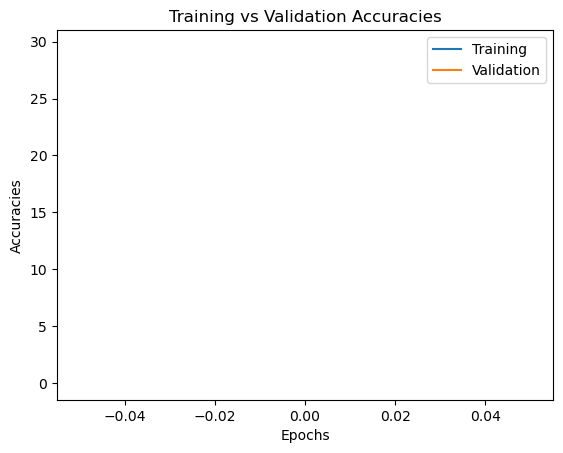

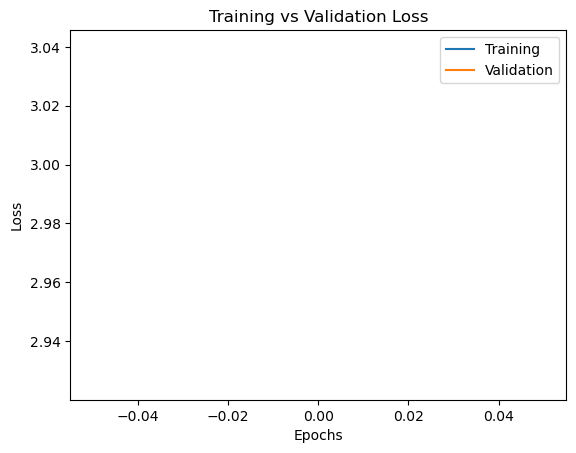

Fold: 2 
Epoch: 1 
Epoch: 1 Train Loss: 2.790459957687697 Train Accuracy: 30.458955630655183
Epoch: 1 Validation Loss: 3.115187883377075 Validation Accuracy: 0.0
Testing Data: Epoch Accuracy: 0.000


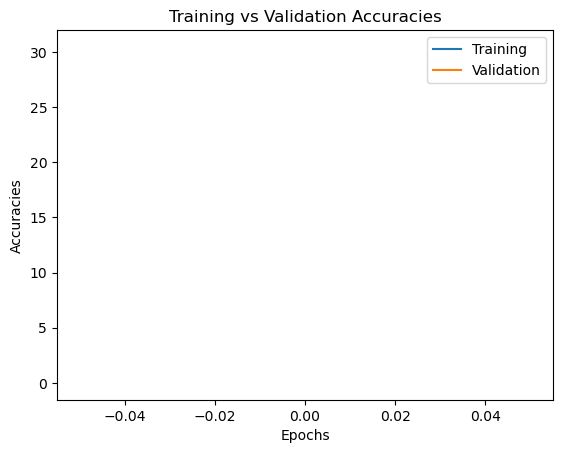

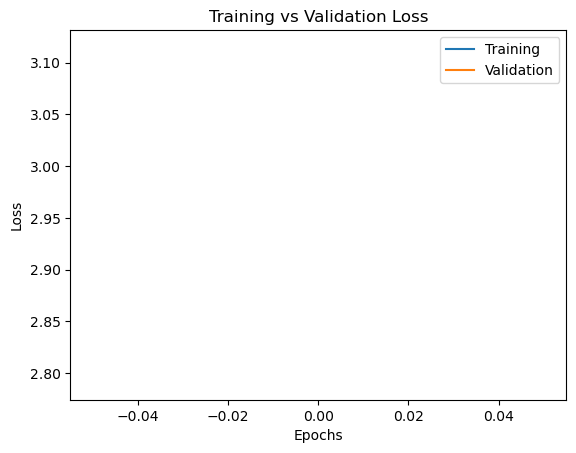

Fold: 3 
Epoch: 1 
Epoch: 1 Train Loss: 2.688183058429678 Train Accuracy: 30.448054071732255
Epoch: 1 Validation Loss: 3.2259788513183594 Validation Accuracy: 0.0


In [ ]:
for fold, (train_indexes, val_indexes) in enumerate(kfold.split(data_t, labels_t)):
    print("Fold: %d "%(fold+1))
    train_data, train_labels = data_t[train_indexes], labels_t[train_indexes]
    val_data, val_labels = data_t[val_indexes], labels_t[val_indexes]
    
    train_dataset = ImageDataset(train_data, train_labels)
    val_dataset = ImageDataset(val_data, val_labels)
    
    train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    val_dataloader = DataLoader(val_dataset, batch_size=32)
    
    n_epochs = 1
    train_losses, train_accuracies = [], []
    val_losses, val_accuracies = [], []
    for epoch in range(n_epochs):
        print("Epoch: %d "%(epoch+1))
        train_epoch_losses, train_epoch_accuracies = [], []
        for i,image_data in enumerate(iter(train_dataloader)):
            images,targets=image_data
            images=images.to(device)
            targets=targets.to(device)
            batch_loss = train_batch(images, targets, model, optimizer, loss_fn)
#             print(batch_loss)
            is_correct = accuracy(images, targets, model)
#             print(is_correct)
            train_epoch_accuracies.extend(is_correct)
            train_epoch_losses.append(batch_loss) 
        train_epoch_loss = np.array(train_epoch_losses).mean()
        train_epoch_accuracy = np.mean(train_epoch_accuracies)*100 
        print('Epoch:',epoch+1,'Train Loss:',train_epoch_loss,'Train Accuracy:',train_epoch_accuracy)
        
        for i,image_data in enumerate(iter(val_dataloader)):
            images,targets=image_data
            images=images.to(device)
            targets=targets.to(device)
            val_is_correct = accuracy(images, targets, model)
            validation_loss = val_loss(images, targets, model)    
            val_epoch_accuracy = np.mean(val_is_correct)*100
        
        print('Epoch:',epoch+1,'Validation Loss:',validation_loss,'Validation Accuracy:',val_epoch_accuracy)
        
        train_losses.append(train_epoch_loss)
        train_accuracies.append(train_epoch_accuracy)
        val_losses.append(validation_loss)
        val_accuracies.append(val_epoch_accuracy)
        
        
        test_acc = evaluate_model(model,test_loader)
        
        plt.plot(range(n_epochs),train_accuracies, label="Training")
        plt.plot(range(n_epochs),val_accuracies, label="Validation")
        plt.xlabel("Epochs")
        plt.ylabel("Accuracies")
        plt.title("Training vs Validation Accuracies")
        plt.legend()
        plt.show()
        
        plt.plot(range(n_epochs),train_losses, label="Training")
        plt.plot(range(n_epochs),val_losses, label="Validation")
        plt.xlabel("Epochs")
        plt.ylabel("Loss")
        plt.title("Training vs Validation Loss")
        plt.legend()
        plt.show()